In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

In [17]:
df = pd.read_csv('data.csv')

In [18]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [19]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-19-02e3f9e08314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-19-02e3f9e08314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-19-02e3f9e08314>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [20]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [21]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-21-fd79ac22a8b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-21-fd79ac22a8b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [42]:
combo_train = pd.concat([x_tr_cont, x_tr_cat], axis=1)

In [43]:
# Create dummy variable for bank account
y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)

<ipython-input-43-b1430f2c33c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)


In [106]:
df_train = pd.concat([combo_train,y_tr],axis=1)

## EDA for target variable: Has bank account (yes/no)
Analysis of train sample (including val)

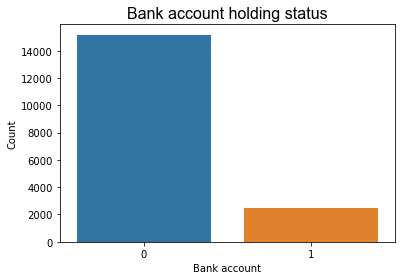

In [45]:
sns.countplot(x='bank_acc', data=df_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Bank account')
plt.ylabel('Count')
plt.show;

In [46]:
count_no_acc = len(df_train[df_train['bank_acc']==0])
count_acc = len(df_train[df_train['bank_acc']==1])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", pct_of_no_acc*100)
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", pct_of_acc*100)

percentage of no account: 85.95476959700731
percentage of account 14.04523040299269


Classes are very __imbalanced__. Suggests I should try adjust the threshold for the decision.

In [109]:
def calculate_pct(feature1,label1,label2,feature2,title):
    df1 = df_train[(df_train[feature1]== label1) & (df_train[feature2]== 1)]
    df1_acc = len(df1)
    df2 = df_train[(df_train[feature1]== label2) & (df_train[feature2]== 0)]
    df2_no_acc = len(df2)
    print(title)
    pct_no_acc = df2_no_acc / (df1_acc + df2_no_acc)
    print("Percentage of no account:", pct_no_acc*100)
    pct_acc = 1-pct_no_acc
    print("Percentage of account", pct_acc*100)

## By country

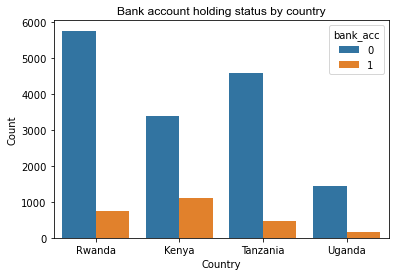

In [47]:
bank_country = sns.countplot(
        data=df_train,
        x="country", hue="bank_acc")
plt.title('Bank account holding status by country',family='arial',fontsize=12)
plt.xlabel('Country')
plt.ylabel('Count');

In [110]:
calculate_pct('country','Rwanda','Rwanda','bank_acc','Rwanda')

Rwanda
Percentage of no account: 88.64648947611
Percentage of account 11.353510523889998


In [99]:
calculate_pct('country','Kenya','Kenya','bank_acc','Kenya')

Kenya
Percentage of no account: 75.08327781479014
Percentage of account 24.91672218520986


In [100]:
calculate_pct('country','Tanzania','Tanzania','bank_acc','Tanzania')

Tanzania
Percentage of no account: 90.70735090152566
Percentage of account 9.292649098474337


In [101]:
calculate_pct('country','Uganda','Uganda','bank_acc','Uganda')

Uganda
Percentage of no account: 90.65656565656566
Percentage of account 9.343434343434343


## By gender

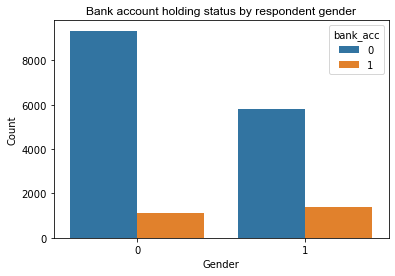

In [49]:
bank_gender = sns.countplot(
        data=df_train,
        x="is_male", hue="bank_acc")
plt.title('Bank account holding status by respondent gender',family='arial',fontsize=12)
plt.xlabel('Gender')
plt.ylabel('Count');

Majority of respondents in the sample identified as female; lower percentage of females have an account in comparison to male respondents

In [102]:
calculate_pct('is_male',1,1,'bank_acc','Male')

Male
Percentage of no account: 80.9285515707534
Percentage of account 19.071448429246594


In [103]:
calculate_pct('is_male',0,0,'bank_acc','Female')

Female
Percentage of no account: 89.41525504832998
Percentage of account 10.584744951670011


## By location type

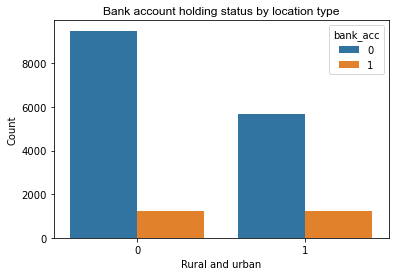

In [79]:
bank_urban = sns.countplot(
        data=df_train,
        x="is_urban", hue="bank_acc")
plt.title('Bank account holding status by location type',family='arial',fontsize=12)
plt.xlabel('Rural and urban')
plt.ylabel('Count');

In [104]:
calculate_pct('is_urban',1,1,'bank_acc','Urban')

Urban
Percentage of no account: 82.04979733642153
Percentage of account 17.950202663578462


In [105]:
calculate_pct('is_urban',0,0,'bank_acc','Rural')

Rural
Percentage of no account: 88.46762925011645
Percentage of account 11.532370749883558


## By education level

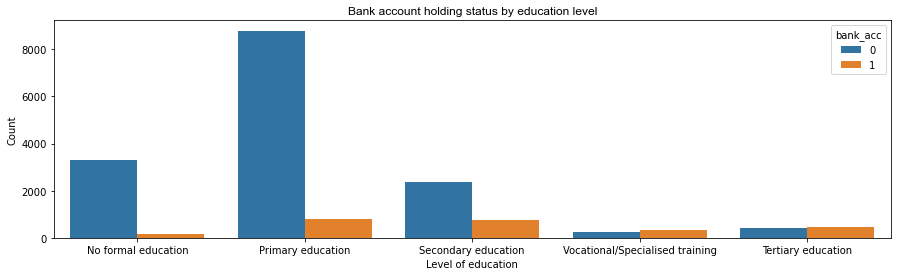

In [52]:
plt.figure(figsize=[15,4])
bank_education = sns.countplot(
        data=df_train,
        x="education_level", hue="bank_acc")
plt.title('Bank account holding status by education level',family='arial',fontsize=12)
plt.xlabel('Level of education')
plt.ylabel('Count');

In [111]:
calculate_pct('education_level','No formal education','No formal education','bank_acc','No formal education')

No formal education
Percentage of no account: 95.80297289419994
Percentage of account 4.197027105800055


In [112]:
calculate_pct('education_level','Primary education','Primary education','bank_acc','Primary education')

Primary education
Percentage of no account: 91.49666944213156
Percentage of account 8.503330557868438


In [113]:
calculate_pct('education_level','Secondary education','Secondary education','bank_acc','Secondary education')

Secondary education
Percentage of no account: 76.41781480294777
Percentage of account 23.58218519705223


In [116]:
calculate_pct('education_level','Vocational/Specialised training','Vocational/Specialised training','bank_acc','Vocational/Specialised training')

Vocational/Specialised training
Percentage of no account: 44.42595673876872
Percentage of account 55.574043261231274


In [117]:
calculate_pct('education_level','Tertiary education','Tertiary education','bank_acc','Tertiary education')

Tertiary education
Percentage of no account: 49.31972789115646
Percentage of account 50.68027210884354


## By relationship with head of household

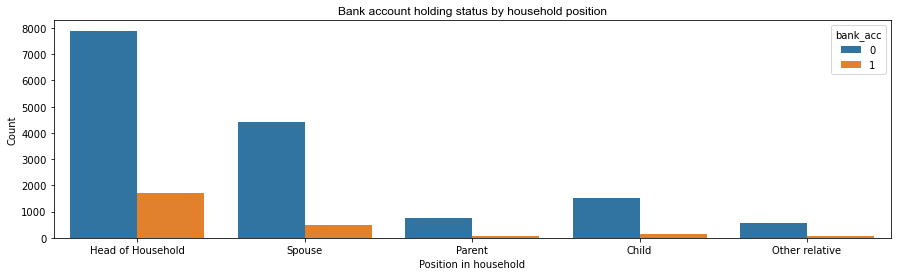

In [53]:
plt.figure(figsize=[15,4])
bank_education = sns.countplot(
        data=df_train,
        x="relationship_with_head", hue="bank_acc")
plt.title('Bank account holding status by household position',family='arial',fontsize=12)
plt.xlabel('Position in household')
plt.ylabel('Count');

In [118]:
calculate_pct('relationship_with_head','Head of Household','Head of Household','bank_acc','Head of Household')

Head of Household
Percentage of no account: 82.15586307356155
Percentage of account 17.84413692643846


In [119]:
calculate_pct('relationship_with_head','Spouse','Spouse','bank_acc','Spouse')

Spouse
Percentage of no account: 89.98578102782857
Percentage of account 10.01421897217144


In [120]:
calculate_pct('relationship_with_head','Parent','Parent','bank_acc','Parent')

Parent
Percentage of no account: 93.4065934065934
Percentage of account 6.593406593406592


In [121]:
calculate_pct('relationship_with_head','Child','Child','bank_acc','Child')

Child
Percentage of no account: 90.99153567110037
Percentage of account 9.008464328899635


In [122]:
calculate_pct('relationship_with_head','Other relative','Other relative','bank_acc','Other relative')

Other relative
Percentage of no account: 89.46540880503144
Percentage of account 10.534591194968556


## By marital status

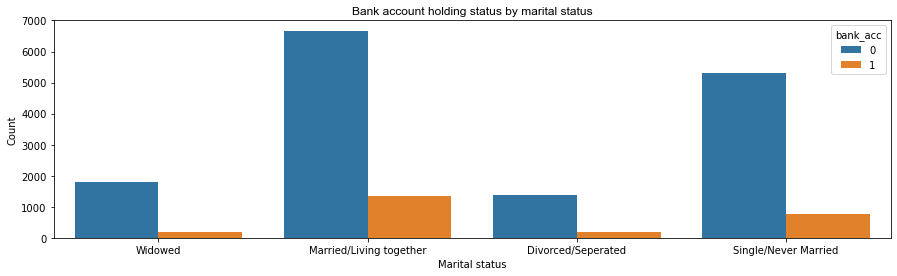

In [54]:
plt.figure(figsize=[15,4])
bank_education = sns.countplot(
        data=df_train,
        x="marital_status", hue="bank_acc")
plt.title('Bank account holding status by marital status',family='arial',fontsize=12)
plt.xlabel('Marital status')
plt.ylabel('Count');

In [124]:
calculate_pct('marital_status','Widowed','Widowed','bank_acc','Widowed')

Widowed
Percentage of no account: 90.44522261130565
Percentage of account 9.554777388694347


In [123]:
calculate_pct('marital_status','Married/Living together','Married/Living together','bank_acc','Married/Living together')

Married/Living together
Percentage of no account: 83.17745354782392
Percentage of account 16.82254645217608


In [125]:
calculate_pct('marital_status','Divorced/Seperated','Divorced/Seperated','bank_acc','Divorced/Seperated')

Divorced/Seperated
Percentage of no account: 87.93548387096774
Percentage of account 12.064516129032254


In [127]:
calculate_pct('marital_status','Single/Never Married','Single/Never Married','bank_acc','Single/Never married')

Single/Never married
Percentage of no account: 87.63786008230453
Percentage of account 12.362139917695469


## By job type

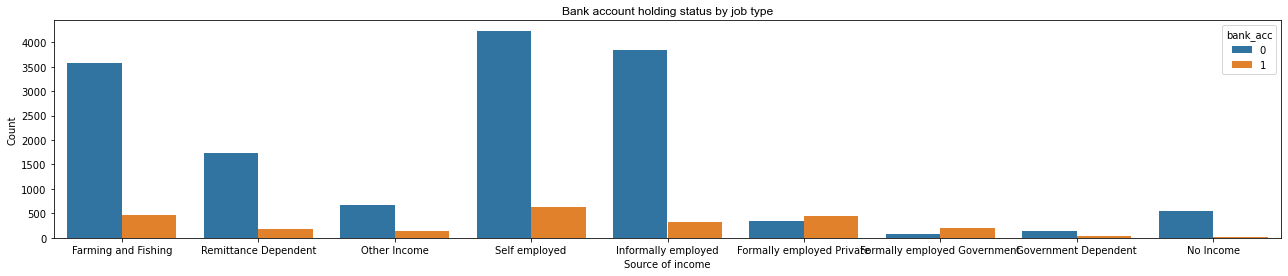

In [129]:
plt.figure(figsize=[22,4])
bank_education = sns.countplot(
        data=df_train,
        x="job_type", hue="bank_acc")
plt.title('Bank account holding status by job type',family='arial',fontsize=12)
plt.xlabel('Source of income')
plt.ylabel('Count');

In [128]:
calculate_pct('job_type','Farming and Fishing','Farming and Fishing','bank_acc','Farming and fishing')

Farming and fishing
Percentage of no account: 88.36174944403261
Percentage of account 11.638250555967389


In [130]:
calculate_pct('job_type','Remittance Dependent','Remittance Dependent','bank_acc','Remittance dependent')

Remittance dependent
Percentage of no account: 90.66736183524505
Percentage of account 9.332638164754957


In [131]:
calculate_pct('job_type','Other Income','Other Income','bank_acc','Other income')

Other income
Percentage of no account: 82.16482164821647
Percentage of account 17.83517835178352


In [132]:
calculate_pct('job_type','Self employed','Self employed','bank_acc','Self employed')

Self employed
Percentage of no account: 86.91282051282052
Percentage of account 13.08717948717949


In [133]:
calculate_pct('job_type','Informally employed','Informally employed','bank_acc','Informally employed')

Informally employed
Percentage of no account: 92.05931595312127
Percentage of account 7.940684046878732


In [134]:
calculate_pct('job_type','Formally employed Private','Formerly employed Private','bank_acc','Formerly employed Private')

Formerly employed Private
Percentage of no account: 0.0
Percentage of account 100.0


In [135]:
calculate_pct('job_type','Formally employed Government','Formerly employed Government','bank_acc','Formerly employed Government')

Formerly employed Government
Percentage of no account: 0.0
Percentage of account 100.0


In [136]:
calculate_pct('job_type','Government Dependent','Government Dependent','bank_acc','Government Dependent')

Government Dependent
Percentage of no account: 78.80434782608695
Percentage of account 21.19565217391305


In [137]:
calculate_pct('job_type','No Income','No Income','bank_acc','No Income')

No Income
Percentage of no account: 96.27659574468085
Percentage of account 3.7234042553191515


## By cellphone access

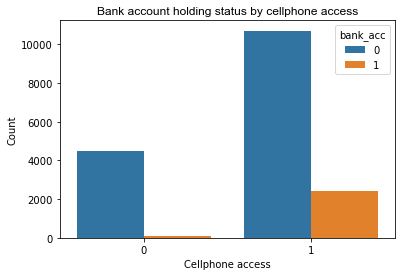

In [138]:
bank_cell = sns.countplot(
        data=df_train,
        x="cellphone", hue="bank_acc")
plt.title('Bank account holding status by cellphone access',family='arial',fontsize=12)
plt.xlabel('Cellphone access')
plt.ylabel('Count');

In [139]:
calculate_pct('cellphone',0,0,'bank_acc','Does not own a cellphone')

Does not own a cellphone
Percentage of no account: 98.11196487376509
Percentage of account 1.8880351262349104


In [140]:
calculate_pct('cellphone',1,1,'bank_acc','Owns a cellphone')

Owns a cellphone
Percentage of no account: 81.72371638141809
Percentage of account 18.276283618581914


In [142]:
df_train.to_excel('bank_train.xlsx')